## Imports 🙅🏻‍♂️🙅🏻‍♀️

In [94]:
import matplotlib
# !pip install opencv-python
import matplotlib.pyplot as ajeeb
import cv2
import math
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import image as mpimg
from matplotlib.pyplot import figure
import seaborn as sns
import numpy as np
%matplotlib inline
from scipy import linalg
from scipy.linalg import null_space
# !pip install imageio
import imageio

### Pre-Processing

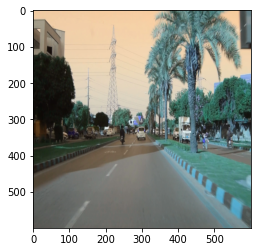

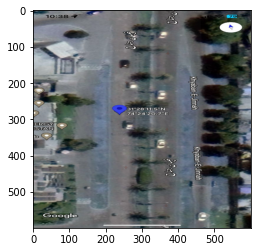

In [95]:
# Add your code here
# Load the two images
def normalize_image(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    normalize_image = cv2.normalize(gray_image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    normalize_image= cv2.resize(image, (600, 600))
    return normalize_image

image1 = cv2.imread('pred7.jpg')  
image2 = cv2.imread('aerial.jpg')

image1 = normalize_image(image1)
image2 = normalize_image(image2)

# Display the two images
# Add your code here
plt.imshow(image1)
plt.show()

plt.imshow(image2) 
plt.show()


### Reading image points

In [110]:
def point_reader(img):
    img_copy = img.copy()
    cv2.namedWindow("Mark Points")
    marked_points = []

    def click_event(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            marked_points.append((x, y))
            # Draw a circle at the clicked point
            cv2.circle(img_copy, (x, y), 5, (0, 255, 0), -1)
            cv2.imshow("Mark Points", img_copy)

    cv2.setMouseCallback("Mark Points", click_event)
    cv2.imshow("Mark Points", img_copy)
    
    while len(marked_points) < 6:
        cv2.waitKey(1)     
    cv2.destroyAllWindows()

    marked_img_path = "marked_image.jpg"
    cv2.imwrite(marked_img_path, img_copy)


    points_array = np.array(marked_points)
    return points_array

In [97]:
# Save your points in an np.array
img1_points = point_reader(image1)
print(img1_points)

[[  7 448]
 [248 348]
 [496 515]
 [315 340]]


### Reading the first image's points

In [98]:
# Save your points in an np.array
img2_points = point_reader(image2)
print(img2_points)

[[205 587]
 [215 169]
 [283 589]
 [279 178]]


In [99]:
# #Temporary points for testing

# temp_points = point_reader(image1)
# print(temp_points)

### Finding Homography (25 Marks)
You are required to calculate the homography matrix H.
$$
\begin{bmatrix}
x'  \\
y'  \\
h 
\end{bmatrix}
=
\begin{bmatrix}
h_1 & h_2 & h_3 \\
h_4 & h_5 & h_6 \\
h_7 & h_8 & h_9
\end{bmatrix}
\times 
\begin{bmatrix}
x  \\
y  \\
1 
\end{bmatrix}
$$
You can use the strategy from WA-1, Q#7 to solve this =)

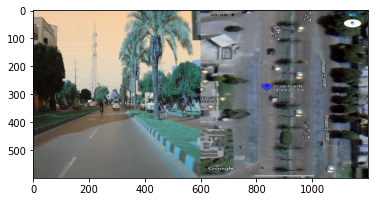

In [100]:
# We are creating the canvas which is essentially the two images joined together
row1, col1 = image1.shape[:2]
row2, col2 = image2.shape[:2]

canvas = np.zeros((max(row1, row2), col1 + col2, 3), dtype='uint8')

# We are placing the first image on the left side of the canvas
canvas[:row1, :col1, :] = image1
# We are placing the second image on the right side of the canvas
canvas[:row2, col1:col1 + col2, :] = image2

# Display the canvas
plt.imshow(canvas)

In [101]:
img2_points[:,0] = img2_points[:,0] + col1

In [102]:
# DUMP YOUR CODE
# We will now zip the points together
points = list(zip(img1_points, img2_points))

homoArray = []
for point1, point2 in points:
    homoArray.append([point1[0], point1[1], 1, 0, 0, 0, -point2[0] * point1[0], -point2[0] * point1[1], -point2[0]])
    homoArray.append([0, 0, 0, point1[0], point1[1], 1, -point2[1] * point1[0], -point2[1] * point1[1], -point2[1]])

homoArray = np.array(homoArray)
print(homoArray)

[[      7     448       1       0       0       0   -5635 -360640    -805]
 [      0       0       0       7     448       1   -4109 -262976    -587]
 [    248     348       1       0       0       0 -202120 -283620    -815]
 [      0       0       0     248     348       1  -41912  -58812    -169]
 [    496     515       1       0       0       0 -437968 -454745    -883]
 [      0       0       0     496     515       1 -292144 -303335    -589]
 [    315     340       1       0       0       0 -276885 -298860    -879]
 [      0       0       0     315     340       1  -56070  -60520    -178]]


### Calculating SVD
This part has been done for you 🙌🏻

In [103]:
# List of useful functions
u, s, vh = np.linalg.svd(homoArray) # Replace it with your H matrix
vh = np.transpose(vh)
P = vh[:,len(vh[0])-1]

P = np.array([P[0:3], P[3:6], P[6:9]])

print("Homography matrix\n",P)

Homography matrix
 [[-3.79532665e-04 -2.13676143e-03  8.02936412e-01]
 [-2.11648019e-04 -1.58270513e-03  5.96057908e-01]
 [-3.88978917e-07 -2.46086189e-06  9.10171045e-04]]


In [104]:
np.save("homography_matrix.npy", P)

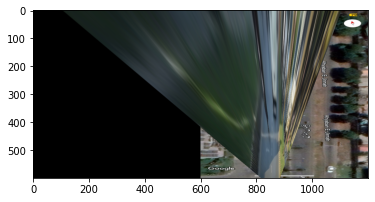

In [105]:
# YOUR CODE
stitchedImage = cv2.warpPerspective(image1, P, (canvas.shape[1], canvas.shape[0]))
stitchedImage[:, image1.shape[1]:, :] = np.where(stitchedImage[:, image1.shape[1]:, :] == 0, image2, stitchedImage[:, image1.shape[1]:, :])
plt.imshow(stitchedImage[:,:,::-1])

In [107]:
homography_matrix = np.load("homography_matrix.npy")
print(homography_matrix)

[[-3.79532665e-04 -2.13676143e-03  8.02936412e-01]
 [-2.11648019e-04 -1.58270513e-03  5.96057908e-01]
 [-3.88978917e-07 -2.46086189e-06  9.10171045e-04]]


Now we open the Yolo Image

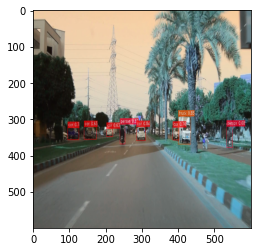

In [108]:
yoImage= cv2.imread('pred7yolo.jpg')
yoImage = normalize_image(yoImage)

plt.imshow(yoImage)
plt.show()

In [111]:
yo_points = point_reader(yoImage)
print(yo_points)

[[245 369]
 [299 358]
 [211 348]
 [155 354]
 [111 358]
 [421 369]]


In [112]:
yo_points = np.array(yo_points)
yo_points = np.column_stack((yo_points, np.ones(yo_points.shape[0])))
print(yo_points)

[[245. 369.   1.]
 [299. 358.   1.]
 [211. 348.   1.]
 [155. 354.   1.]
 [111. 358.   1.]
 [421. 369.   1.]]


In [137]:
yo_transpose = yo_points.T
result = homography_matrix @ yo_transpose

result = result.T
result

array([[-7.85140592e-02, -3.98140512e-02, -9.31868282e-05],
       [-7.55044473e-02, -3.38332877e-02, -8.71222088e-05],
       [-2.07379585e-02,  6.18789303e-04, -2.82834452e-05],
       [-1.23046979e-02,  2.97484757e-03, -2.12657972e-05],
       [-4.15230635e-03,  5.95653987e-03, -1.39941725e-05],
       [-1.45311808e-01, -7.70641025e-02, -1.61647117e-04]])

In [138]:
third_column = result[:, 2].reshape(-1, 1)
result[:, :2] /= third_column
result = result[:, :2]
result

array([[ 842.54460342,  427.24977292],
       [ 866.64982815,  388.34285981],
       [ 733.21896724,  -21.87814455],
       [ 578.61446364, -139.88883348],
       [ 296.71681962, -425.64430879],
       [ 898.94462953,  476.7428194 ]])

Plotting

In [139]:
import matplotlib.pyplot as plt 
from matplotlib.patches import Ellipse

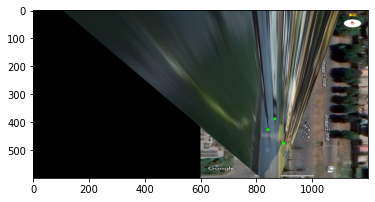

In [158]:
points = np.array(result)
stitchedImage = stitchedImage[:,:,::-1]
img_copy = stitchedImage.copy()

for point in points:
    cv2.circle(img_copy, tuple(map(int, point)), 5, (0, 255, 0), -1)

plt.imshow(img_copy)
plt.show()